In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import  train_test_split
import copy
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [3]:
failures = pd.read_csv('./data/model_data/failures.csv',sep=',')
components = failures['Component'].unique()

In [4]:
encoder = LabelEncoder()
for component in components:
    globals()[f"{component}_df"] = pd.read_csv(f'./data/model_data/labelled_data_{component}.csv',sep=',')
    globals()[f"{component}_df"]['Turbine_ID'] = encoder.fit_transform(['Turbine_ID']*globals()[f"{component}_df"].shape[0])
    # set the date as the index
    globals()[f"{component}_df"] = globals()[f"{component}_df"].set_index('Timestamp')

In [5]:
class_target_name = "Failure (Target)"
for component in components:
    X = globals()[f"{component}_df"].drop(columns=['Component',class_target_name])
    y = globals()[f"{component}_df"][class_target_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    globals()[f"{component}_X_train"] = X_train
    globals()[f"{component}_X_test"] = X_test
    globals()[f"{component}_y_train"] = y_train
    globals()[f"{component}_y_test"] = y_test

In [7]:
model_name = "xgb"

In [9]:

for component in components:

    with open("./main_pipeline/model/{}_{}.pickle".format(model_name, component), "rb") as f:
        globals()[f"{model_name}_{component}"] = pickle.load(f)

In [10]:
def train_runs_XGB(X_train, y_train, model):
    clf = ExtraTreesClassifier(n_estimators=50)
    tree_selector = SelectFromModel(clf)
   
    base_estimator = model
    base_estimator.steps.insert(-1, ["selector", tree_selector])
    param_grid = {

        "selector__max_features": Integer(5, 100),
        "{}__max_depth".format(model_name): [10, 20, 40, 80],
        "{}__n_estimators".format(model_name): [50, 100, 200],
        "{}__learning_rate".format(model_name): Real(0.01, 0.2, prior='log-uniform')

    }
    bayes_search = BayesSearchCV(
        estimator=base_estimator,
        search_spaces=param_grid,
        scoring="f1_weighted",
        n_iter=50,
        cv=5,
        verbose=2,
        random_state=0,
        n_jobs=-1
    )

    bayes_search.fit(X_train, y_train)
    results = bayes_search.cv_results_
    best_clf = bayes_search.best_estimator_

    return best_clf, results, param_grid

In [ ]:
best_clf, results, param_grid = train_runs_XGB(GEARBOX_X_train, GEARBOX_y_train, xgb_GEARBOX)

In [14]:
# Assuming X_train is a pandas DataFrame and you have best_clf from train_runs_XGB function

import numpy as np

# Access the SelectFromModel instance from the pipeline
tree_selector = best_clf.named_steps['selector']

# Fit the selector on X_train to determine selected features
tree_selector.fit(X_train, y_train)

# Get the mask of selected features
feature_mask = tree_selector.get_support()

# Get the list of feature names from X_train
feature_names = X_train.columns.tolist()

# Filter feature names using the boolean mask
selected_feature_names = np.array(feature_names)[feature_mask].tolist()

# Print selected feature names
print("Selected Features:")
print(selected_feature_names)


Selected Features:
['Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Hyd_Oil_Temp_Avg', 'Gear_Oil_Temp_Avg', 'Nac_Temp_Avg', 'Amb_WindSpeed_Max', 'Amb_WindDir_Abs_Avg', 'Amb_Temp_Avg', 'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ReactPwrGen0', 'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Cont_Hub_Temp_Avg', 'Cont_VCP_Temp_Avg', 'Gen_SlipRing_Temp_Avg', 'Spin_Temp_Avg', 'Blds_PitchAngle_Max', 'Blds_PitchAngle_Avg', 'Grd_RtrInvPhase1_Temp_Avg', 'Grd_RtrInvPhase3_Temp_Avg', 'Cont_VCP_WtrTemp_Avg', 'Grd_Prod_CosPhi_Avg', 'Grd_Prod_VoltPhse1_Avg', 'Grd_Prod_VoltPhse2_Avg', 'Grd_Prod_VoltPhse3_Avg', 'Grd_Busbar_Temp_Avg', 'Grd_Prod_ReactPwr_Max', 'Grd_Prod_PsblePwr_Avg', 'Grd_Prod_PsbleInd_Avg', 'Grd_Prod_PsbleInd_Max', 'Grd_Prod_PsbleInd_Std', 'Gen_Bear2_Temp_Avg', 'Nac_Direction_Avg', 'Min_AmbientTemp', 'Avg_AmbientTemp']


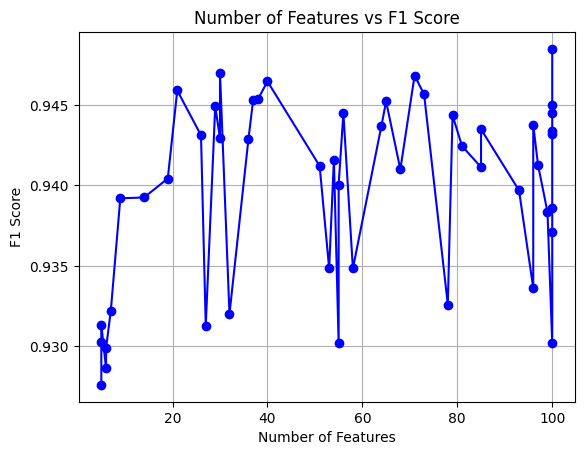

In [15]:
# sort the number of features and their performance
def plot_feature_performance(results, param_grid):
    fig, ax = plt.subplots()
    max_features_list = [results["params"][i]["selector__max_features"] for i in range(len(results["params"]))]
    scores = [results["mean_test_score"][i] for i in range(len(results["mean_test_score"]))]

    max_features_list, scores = zip(*sorted(zip(max_features_list, scores)))
    ax.plot(max_features_list, scores, marker='o', color='blue', linestyle='-')
    
    ax.set_xlabel("Number of Features")
    ax.set_ylabel("F1 Score")
    ax.set_title("Number of Features vs F1 Score")
    plt.grid(True)
    plt.show()
plot_feature_performance(results, param_grid)

In [16]:
# print number offeature with highest performance
def get_best_features(results):
    best_score = max(results["mean_test_score"])
    best_index = results["mean_test_score"].tolist().index(best_score)
    best_features = results["params"][best_index]["selector__max_features"]
    return best_features

In [17]:
get_best_features(results)

100

In [9]:
# i have features 104, and want to creatse a list to provide for hyperparameter tuning, number of different features 
#print all the values of a
#  "selector__max_features": Integer(5, 100) instead provide a list of values list(range(5, 100, 5))
# increase the number of values in b

b=Integer(5, 104)
#a = list(range(10, 104, 10))
#print(a)
#all the values of b

print(b.rvs(10))


[21 69  6 50 18 90 52 91 48 26]


In [ ]:
def train_runs_XGB(X_train, y_train, model):
    clf = ExtraTreesClassifier(n_estimators=50)
    tree_selector = SelectFromModel(clf)
    univariate_selector1 = SelectKBest(f_classif, k=3)
    univariate_selector2 = SelectKBest(f_classif, k=6)
    univariate_selector3 = SelectKBest(f_classif, k=7)
    base_estimator = model
    base_estimator.steps.insert(-1, ["selector", tree_selector])
    param_grid = {

        #"selector__max_features": list(range(10, 104,10)),
        "selector": ["passthrough", univariate_selector1, univariate_selector2, univariate_selector3, tree_selector],
        "{}__max_depth".format(model_name): [10, 20, 40, 80],
        "{}__n_estimators".format(model_name): [50, 100, 200],
        "{}__learning_rate".format(model_name): Real(0.01, 0.2, prior='log-uniform')

    }
    bayes_search = BayesSearchCV(
        estimator=base_estimator,
        search_spaces=param_grid,
        scoring="f1_weighted",
        n_iter=50,
        cv=5,
        verbose=2,
        random_state=0,
        n_jobs=-1
    )

    bayes_search.fit(X_train, y_train)
    results = bayes_search.cv_results_
    best_clf = bayes_search.best_estimator_

    return best_clf, results, param_grid

In [7]:
a=list(range(1, X_train.shape[1] + 1))
a

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104]

In [4]:
a = Integer(5, 50)
# print the values of a
print(a.rvs(10))

[20 20 17 12 10  8 14 17 11  8]
